# Model Selection

The aim of this notebook is to select a set of features that can be used to train models to detect the 'rainbow effect' of trucks.

We will be using sklearn, and using an RFC model for now

## Setup

In [1]:
import os, sys
import pandas as pd
import numpy as np

# Scikit-Learn:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, scale
from sklearn.metrics import accuracy_score, balanced_accuracy_score, RocCurveDisplay
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE, SequentialFeatureSelector, SelectKBest, f_classif

# Graphing:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {"font": "Arial"})

## Importing data

In [2]:
features = pd.read_csv("../data/all_training_features.csv")

all_feature_cols = [x for x in features.columns if x not in {'Unnamed: 0', 'validation', 'ml_class', 'date', 'location'}]

label_col = "ml_class"

## Preprocessing data

In [3]:
# Dropping duplicated rows:
features = features.drop(features.index[features.duplicated()]).reset_index(drop=True)

In [4]:
# Train - test split
train, test = train_test_split(features, test_size=0.2, random_state=1, stratify=features['ml_class'])

In [5]:
# Create X_train, Y_train, X_test, Y_test
X_train = train[all_feature_cols]
Y_train = train[label_col]
X_test = test[all_feature_cols]
Y_test = test[label_col]

In [6]:
# Scaling data
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(sc.transform(X_test), index=X_test.index, columns=X_test.columns)

## Feature Selection

Attempting to select features to optimise model training

### Random Forest Importance

(Train a random forest classifier and then calculating the Gini index / mean decrease in impurity)

In [7]:
# Setup and train RFC:
rfc = RandomForestClassifier(n_estimators=100, random_state=10)
rfc.fit(X_train_scaled, Y_train)

RandomForestClassifier(random_state=10)

In [8]:
# Calculating mean importances & variance
importances = rfc.feature_importances_
standard_deviations = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
plot_data_2 = pd.Series(importances, index=all_feature_cols)
plot_data = pd.DataFrame({"feature": all_feature_cols, "importance":importances, "stderr": standard_deviations})

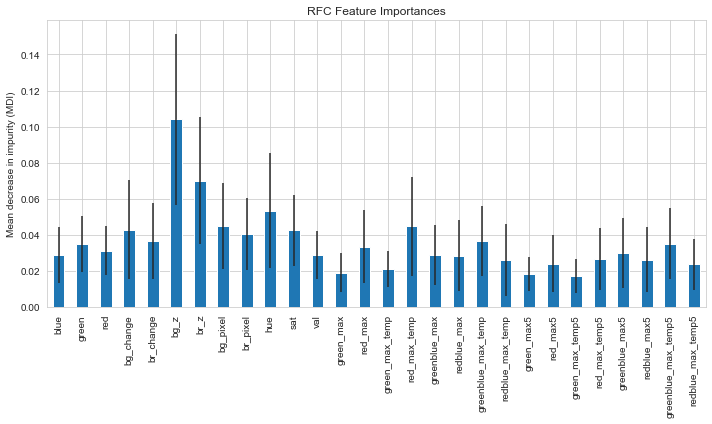

In [9]:
# Plotting feature importances
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
# plt.bar(x = plot_data.feature, height=plot_data.importance, yerr=plot_data.stderr)
plot_data_2.plot.bar(yerr=standard_deviations, ax=ax)
ax.set_title("RFC Feature Importances")
ax.set_ylabel("Mean decrease in impurity (MDI)")
fig.tight_layout()

### Recursive Feature Elimination

Recursively training an RFC, but at each step removing the feature with the lowest importance, until a specific number of features is reached

In [10]:
estimator = RandomForestClassifier(n_estimators=100, random_state=10)
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train_scaled, Y_train)

In [12]:
pd.DataFrame({'feature': all_feature_cols, 'ranking': selector.ranking_}).sort_values('ranking')

,feature,ranking
1,green,1
9,hue,1
5,bg_z,1
6,br_z,1
15,red_max_temp,1
7,bg_pixel,2
18,greenblue_max_temp,3
10,sat,4
8,br_pixel,5
16,greenblue_max,6


### ANOVA (Analysis Of Variance)

ANOVA is a statistical method to identify variables of high importance (that explain much of the variance in the data/feature space). We repeatedly perform statistical $F$-tests, starting with one feature and adding on an additional feature each time until all features are accounted for. We can also obtain the $p$-value for each variable, and if we so wanted, could perform a hypothesis test for significance with a set $p$.

(This is a somewhat condensed explanation and may not be entirely accurate)

In [13]:
# configure to select all features
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(X_train_scaled, Y_train)

SelectKBest(k='all')

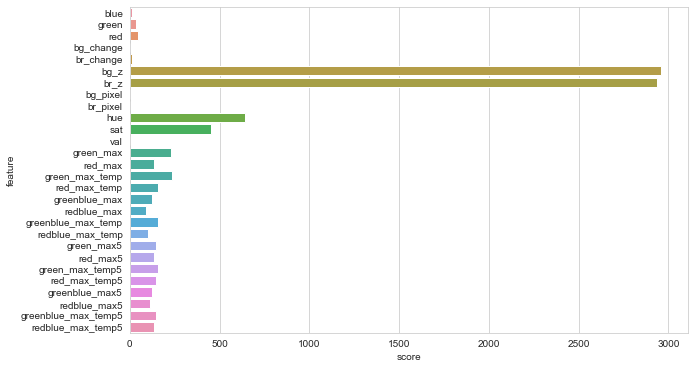

In [16]:
# Plotting feature importances
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)
# 
sns.barplot(data = pd.DataFrame({'feature': all_feature_cols, 'score': fs.scores_}), y="feature", x="score", ax=ax)
plt.show()

## Observations:

 - `bg_z`, `br_z` consistently rank high for each method of feature selection
 - However, we have conflicting rankings for most of the other features
 - Other methods we didn't try include:
    - Principle Components Analysis
    - Singular Value Decomposition
    - Sequential Feature Selection (below)

### Sequential Feature Selection

This is quite computationally expensive and takes a long time to run:

In [15]:
# Any more than 2 features takes a long time
# sfs_forward = SequentialFeatureSelector(estimator, n_features_to_select=2, direction="forward")
# sfs_forward = sfs_forward.fit(X_train_scaled, Y_train)
# print("Features selected by forward sequential selection:")
# print(feature_names[sfs_forward.get_support()])